In [23]:
from traitlets.config.configurable import Configurable
from traitlets import HasTraits, Int, Float, Unicode, Bool, Any, Dict, List, default, Type
import ipywidgets as widgets

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np

from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.calc import get_wind_components
from metpy.units import units
from metpy.cbook import get_test_data
from metpy.io.gini import GiniFile
from metpy.plots.ctables import registry


class MetpyMap(Configurable):

    file_location = Unicode(allow_none=False, help='location of the data file').tag(config=True)

    bbox = Dict(traits={"east": Float(allow_none=False), "west": Float(allow_none=False),
                        "north": Float(allow_none=False), "south": Float(allow_none=False)},
                help='map bounding box').tag(config=True) 
    
    feature_choices = Dict(trait=Any(), 
                           help='Available features to toggle on or off').tag(config=True)
    
    features = Dict(trait=Bool(),
                    help='Toggle features to draw').tag(config=True)

    projection_options = Dict(traits={"from_proj": Any(), 
                                      "to_proj": Any()},
                              help='projection options').tag(config=True)
    
    @default('feature_choices')
    def _feature_choices_default(self):
        
        avail_features = {
                          'OCEANS': cartopy.feature.OCEAN,
                          'LAKES': cartopy.feature.LAKES, 
                          'RIVERS': cartopy.feature.RIVERS,
                          'LAND': cartopy.feature.LAND,
                          'COASTLINE': cartopy.feature.COASTLINE,
                          'BORDERS': cartopy.feature.BORDERS, 
                          'STATES': cartopy.feature.NaturalEarthFeature(
                                    category='cultural',
                                    name='admin_1_states_provinces_lakes',
                                    scale='50m',
                                    facecolor='none')
                         }
        
        return avail_features
    
    @default('features')
    def _features_default(self):
        return dict({f : False for f in self.feature_choices.keys()})
    
    @default('projection_options')
    def _projection_options_default(self):
        return dict(from_proj=None, to_proj=None)
    
    @default('bbox')
    def _bbox_default(self):
        return dict(east=-70, west=-120, north=50, south=25)
                    
    
    def draw_map(self, view):

        view.set_extent([self.bbox['west'], self.bbox['east'], 
                         self.bbox['south'], self.bbox['north']])

        for key, activated in self.features.items():
            if activated:
                view.add_feature(self.feature_choices[key])
            
        return view


class StationMap(MetpyMap):
    
    def __init__(self):
        
        self.data = None
        
    def load_text(self):

        f = get_test_data(self.file_location)

        all_data = np.loadtxt(f, skiprows=1, delimiter=',',
                              usecols=(1, 2, 3, 4, 5, 6, 7, 17, 18, 19),
                              dtype=np.dtype([('stid', '3S'), ('lat', 'f'), ('lon', 'f'),
                                              ('slp', 'f'), ('air_temperature', 'f'),
                                              ('cloud_fraction', 'f'), ('dewpoint', 'f'),
                                              ('weather', '16S'),
                                              ('wind_dir', 'f'), ('wind_speed', 'f')]))

        all_stids = [s.decode('ascii') for s in all_data['stid']]

        whitelist = ['OKC', 'ICT', 'GLD', 'MEM', 'BOS', 'MIA', 'MOB', 'ABQ', 'PHX', 'TTF',
                     'ORD', 'BIL', 'BIS', 'CPR', 'LAX', 'ATL', 'MSP', 'SLC', 'DFW', 'NYC', 'PHL',
                     'PIT', 'IND', 'OLY', 'SYR', 'LEX', 'CHS', 'TLH', 'HOU', 'GJT', 'LBB', 'LSV',
                     'GRB', 'CLT', 'LNK', 'DSM', 'BOI', 'FSD', 'RAP', 'RIC', 'JAN', 'HSV', 'CRW',
                     'SAT', 'BUY', '0CO', 'ZPC', 'VIH']

        # Loop over all the whitelisted sites, grab the first data, and concatenate them
        self.data = np.concatenate([all_data[all_stids.index(site)].reshape(1, ) for site in whitelist])
    
    
    def draw_map(self, view):

        from_proj = self.projection_options['from_proj']

        view = MetpyMap.draw_map(self, view)

        x = self.data['lon']
        y = self.data['lat']

        u, v = get_wind_components((self.data['wind_speed'] * units('m/s')).to('knots'),
                                    self.data['wind_dir'] * units.degree)

        stationplot = StationPlot(view, x, y, transform=from_proj,
                                  fontsize=12)

        stationplot.plot_parameter('NW', self.data['air_temperature'], color='red')
        stationplot.plot_parameter('SW', self.data['dewpoint'], color='darkgreen')

        stationplot.plot_parameter('NE', self.data['slp'],
                                   formatter=lambda sp: format(10 * sp, '.0f')[-3:])

        stationplot.plot_barb(u, v)

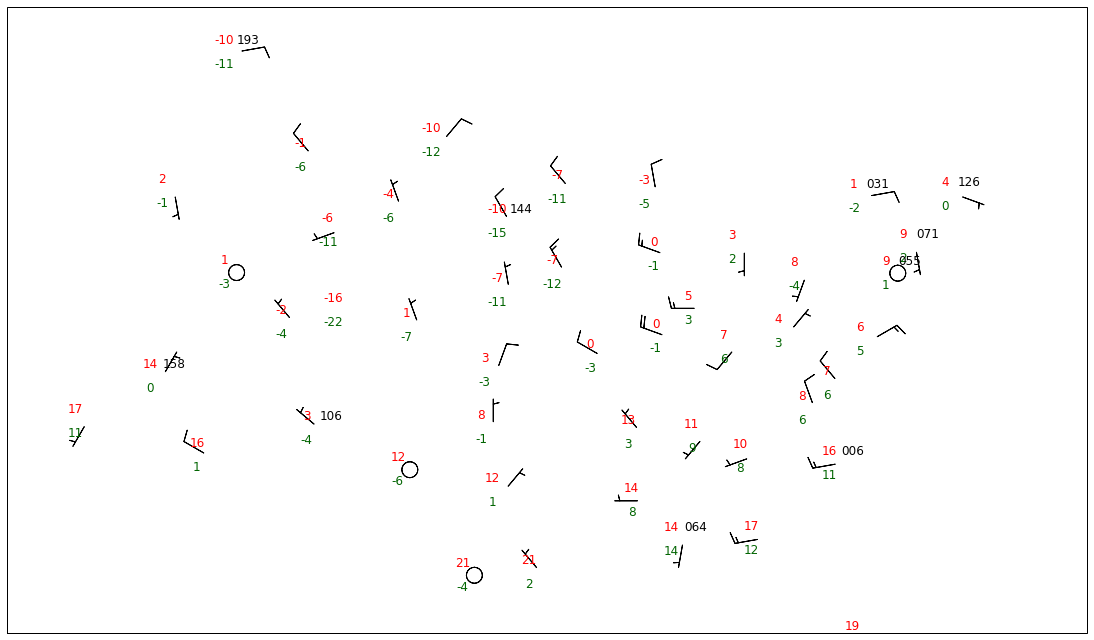

In [29]:
from ipywidgets import interact
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

from_proj = ccrs.Geodetic()
to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)

f = GiniFile(get_test_data('WEST-CONUS_4km_WV_20151208_2200.gini'))

ds = f.to_dataset()
x = ds.variables['x'][:]
y = ds.variables['y'][:]
dat = ds.variables['WV']
proj_var = ds.variables[dat.grid_mapping]

globe = ccrs.Globe(ellipse='sphere', semimajor_axis=proj_var.earth_radius,
                   semiminor_axis=proj_var.earth_radius)
proj = ccrs.LambertConformal(central_longitude=proj_var.longitude_of_central_meridian,
                             central_latitude=proj_var.latitude_of_projection_origin,
                             standard_parallels=[proj_var.standard_parallel],
                             globe=globe)


wv_norm, wv_cmap = registry.get_with_steps('WVCIMSS', 0, 1)

long_range = (-120, -60, 5)
lat_range = (20, 50, 5)

sp = StationMap()

sp.projection_options['to_proj'] = to_proj
sp.projection_options['from_proj'] = from_proj
sp.file_location = "station_data.txt"

sp.load_text()

view = plt.axes([0, 0, 1, 1], projection=to_proj)

# if wvoverlay:

#     xmn, ymn = to_proj.transform_point(x.min(), y.min(), proj)
#     xmx, ymx = to_proj.transform_point(x.max(), y.max(), proj)
#     view.imshow(dat[:], cmap=wv_cmap, norm=wv_norm, zorder=0,
#            extent=(xmn, xmx, ymn, ymx), origin='upper')

sp.draw_map(view)     

In [ ]:
sp.projection